<a href="https://colab.research.google.com/github/Habonit/sparta_coding_ai/blob/main/week3_advanced_mlni_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU kagglehub datasets torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# MLNI

Multi-genre natural language inference(MNLI): MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제입니다. 감정 분석과 같은 sentence classification이지만 문장이 두 개 주어집니다. 이 링크의 data를 활용하시면 됩니다. Test data는 validation_matched.csv를 활용하시면 됩니다.

    

# Week3 advanced MNLI

1) 텍스트 분류 문제에 해당합니다.

2) 사용 모델: Distill Bert


## 1 [My Code] Preparation

- 데이터셋에서 premise(전제) / hypothesis(가설) / label 이렇게 3가지만 필요하여 다른 칼럼은 모두 drop 하겠습니다.

- label

    1) 0: entailment

    2) 1: neutral

    3) 2: contradiction

- validation

    1) Matched Validation:

        1) 정의: 훈련 세트와 동일한 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.
    
        2) 목적: 모델이 훈련된 도메인 내에서 얼마나 잘 일반화하는지 평가합니다.
    
        3) 구분: fiction	government	slate	telephone	travel
    
    2) Mismatched Validation:

        1) 정의: 훈련 세트에 없는 다른 장르에서 추출된 문장 쌍으로 구성된 검증 세트입니다.

        2) 목적: 모델이 새로운 도메인이나 장르에 대해 얼마나 잘 일반화하는지 평가합니다.

        3) 구분: facetoface	letters	nineeleven	oup	verbatim

    

### 1.1 [My Code] Load Dataset, Tokenizer, Model

In [ ]:
import kagglehub
import pandas as pd
from pathlib import Path
from IPython.display import display
# 데이터 다운로드
# validation_matched는 train과 동일 장르를 포함합니다.
# validation_mismatched는 train과 다른 장르만 포함합니다.
# 앞으로 이런 데이터셋을 zeroshot 데이터셋이라 하겠습니다.
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

dir_path = Path(path)
train_path = dir_path / "train.csv"
validation_matched = dir_path / "validation_matched.csv"
validatoin_mismatched = dir_path / "validation_mismatched.csv"

# 사용하려는 칼럼인 premise, hypothesis, label, genre만 추출하겠습니다.
# 예시 데이터는 1000개만 사용합니다.
# 본 과제에서는 주석처리할 예정입니다.
col_lst = ['premise','hypothesis','label','genre']
data_lst = ['train_df', 'matched_val_df', 'mismatched_val_df']
train_df = pd.read_csv(train_path)[col_lst]

matched_val_df = pd.read_csv(validation_matched)[col_lst]

mismatched_val_df = pd.read_csv(validatoin_mismatched)[col_lst]

100%|██████████| 109M/109M [00:01<00:00, 109MB/s] 

Extracting files...


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torchinfo import summary
import torch
from pprint import pprint

# 모델 config입니다.
model_name = "distilbert/distilbert-base-uncased"

test_size = 0.2
random_state = 42
batch_size = 256
max_len = 400

results_dir = './results/week3_advanced'
lr = 2e-5

# 테스트 시에는 3에폭으로 했습니다
# 이후에는 30에폭을 진행해볼 생각입니다.
n_epochs = 30

# bert tokenizer를 사용합니다.
# huggingface에서 distill bert를 불러올 시 num label을 부여하여 classifier를 자동으로 달 수 있습니다.
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

pprint(summary(model, input_size = (batch_size, max_len), dtypes=[torch.int64]))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [256, 3]                  --
├─DistilBertModel: 1-1                                  [256, 400, 768]           --
│    └─Embeddings: 2-1                                  [256, 400, 768]           --
│    │    └─Embedding: 3-1                              [256, 400, 768]           23,440,896
│    │    └─Embedding: 3-2                              [1, 400, 768]             393,216
│    │    └─LayerNorm: 3-3                              [256, 400, 768]           1,536
│    │    └─Dropout: 3-4                                [256, 400, 768]           --
│    └─Transformer: 2-2                                 [256, 400, 768]           --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [256, 768]                590,592
├─Dropout: 1-3                 

In [ ]:
# 사전과 모델의 config를 확인합니다.
word2idx = {name: id for name, id in sorted(tokenizer.vocab.items(), key=lambda x: x[1])}
pprint(f"Vocab len: {tokenizer.vocab_size}")
pprint(list(word2idx.items())[:10])
print()
pprint(model.config)

'Vocab len: 30522'
[('[PAD]', 0),
 ('[unused0]', 1),
 ('[unused1]', 2),
 ('[unused2]', 3),
 ('[unused3]', 4),
 ('[unused4]', 5),
 ('[unused5]', 6),
 ('[unused6]', 7),
 ('[unused7]', 8),
 ('[unused8]', 9)]

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert/distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.47.1",
  "vocab_size": 30522
}



In [ ]:
# 추후 사용할 모델에 parameter를 동결하고 최후의 classifier만 trainable로 사용합니다.
# 학습 가능한 파라미터수가 10% 내로 줄어 60만 개 정도로 확인됩니다.
def build_model(freeze=True):
    # 모델 로드
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

    # 분류기 이전의 모든 파라미터 동결
    if freeze:
        for param in model.distilbert.parameters():
            param.requires_grad = False
    return model

model = build_model()
pprint(summary(model, input_size = (batch_size, max_len), dtypes=[torch.int64]))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [256, 3]                  --
├─DistilBertModel: 1-1                                  [256, 400, 768]           --
│    └─Embeddings: 2-1                                  [256, 400, 768]           --
│    │    └─Embedding: 3-1                              [256, 400, 768]           (23,440,896)
│    │    └─Embedding: 3-2                              [1, 400, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [256, 400, 768]           (1,536)
│    │    └─Dropout: 3-4                                [256, 400, 768]           --
│    └─Transformer: 2-2                                 [256, 400, 768]           --
│    │    └─ModuleList: 3-5                             --                        (42,527,232)
├─Linear: 1-2                                           [256, 768]                590,592
├─Dropout: 1-3         

### 1.2 [My Code] 결측치 확인 및 제거

- train_df의 hypothesis에 40개의 결측치가 있음이 확인되었습니다.

- 그 외에 결측치가 확인되지 않아 train_df의 결측치만 모두 제거하였습니다.

In [ ]:
import numpy as np
result = np.array([df.isna().sum().values for df in [train_df, matched_val_df, mismatched_val_df]])
result = pd.DataFrame(result)
result.index = data_lst
result.columns = col_lst
display(result)
print("\n"*3)
# hypothesis가 결측된 데이터의 행을 확인해보았습니다.
# 별다른 특징은 보이지 않아 모두 제거하였습니다.
display(train_df[train_df['hypothesis'].isna()].head())

,premise,hypothesis,label,genre
train_df,0,40,0,0
matched_val_df,0,0,0,0
mismatched_val_df,0,0,0,0


,premise,hypothesis,label,genre
118,"Native 'Me win, me passum heap big law ...",NaN,2,slate
3318,Saint-Germain-des-Pr??s,NaN,1,travel
10612,weatherwise or otherwise weatherwise,NaN,0,telephone
19990,AICPA American Institute of Certified Public A...,NaN,2,government
34685,Tony Shoes (so Clinton will have Shoes and So...,NaN,0,slate


In [ ]:
train_df = train_df.dropna(how='any').reset_index(drop=True)

### 1.3 [My Code] EDA (1) - 라벨에 따른 premise, hypothesis확인


In [ ]:
from itertools import product
# 라벨에 따른 premise hypothesis 확인
def show_data(df, label, sample_num=2):
    display(df[df['label'] == label][['premise','hypothesis']].sample(sample_num))

for df, label in product([train_df, matched_val_df, mismatched_val_df],[0,1,2]):
    print(f"{label} 라벨")
    show_data(df, label)


0 라벨


,premise,hypothesis
285505,The efficient justice arrives at the court aro...,Justices are able to leave by 3.
10043,"On this basis, attorney Charles (Rick) Rule, w...",They were accused of suing to help a competitor.


1 라벨


,premise,hypothesis
392342,you start um the dollar value on things,You start with the dollar value and then move ...
303061,"With what you knew, and what you didn't know.",You don't know what you know and you know what...


2 라벨


,premise,hypothesis
291705,The Biblioteca Ambrosena (Piazza Pio XI) has r...,The Biblioteca Ambrosena was never reopened.
234532,"In many cases, and often for the same rate, a ...",A piece can only be handwritten if you are the...


0 라벨


,premise,hypothesis
7778,"First, get the basics right, that is, the bloc...",The basics need to be right first.
6267,I found Steven E. Landsburg's piece Pay Scales...,I was unimpressed by Landsburg's pay Scales in...


1 라벨


,premise,hypothesis
1999,"According to this plan, areas that were predom...",We want to give Palestine and Israel a two-sta...
3512,i think yeah and it's a just a nice escape and...,It's an escape that is short-lived.


2 라벨


,premise,hypothesis
4907,"My own little corner of the world, policy wonk...",An example is birdwatching.
3024,His authoritarian rule has prevented the emerg...,"Because of his lax ruling, many other politica..."


0 라벨


,premise,hypothesis
8334,All five hijackers passed through the Main Ter...,United Airlines contracted security screening ...
303,"At 9:39, the FAA's Cleveland Air Route Traffic...",The FAA's Cleveland Air Route Traffic Control ...


1 라벨


,premise,hypothesis
5341,That sounds dangerous.,Wrestling with crocodiles does not sound healthy.
5181,Sarah hung out with another family in the neig...,Sarah spent time with her sister.


2 라벨


,premise,hypothesis
3540,"Uh, well, would you care to relate the story t...",I understand how you may not be able to relate.
3543,"A number of developments, many linked to issue...",Retailing electronically has no potential and ...


### 1.4 [My Code] EDA (2) - 라벨 분포도 확인


In [ ]:
# 라벨 분포도 확인
# 라벨 분포도는 train_df, matched_val_df, mismatched_val_df 모두 고르게 분포되어 있음을 알 수 있습니다.
# 클래스 수는 3개이므로 3개 다중 분류 모델링을 해야 합니다.
result = [df['label'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df, mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df",'mismatched_val_df']
display(result_df)

label,0,1,2
train_df,0.333330,0.333332,0.333338
matched_val_df,0.354457,0.318186,0.327356
mismatched_val_df,0.352217,0.318247,0.329536


### 1.5 [My Code] EDA (3)-장르 분포도 확인



In [ ]:
# genre 분포도 확인
# genre의 수는 5개로로 나뉘며 고르게 분포되어 있음을 알 수 있습니다.
# 그러면서 mismatched_df만 genre 분포가 아예 다르다는 것을 알 수 있습니다.
result = [df['genre'].value_counts(normalize=True).sort_index() for df in [train_df, matched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["train_df","matched_val_df"]
display(result_df)

result = [df['genre'].value_counts(normalize=True).sort_index() for df in [mismatched_val_df]]
result_df = pd.DataFrame(result).reset_index(drop=True)
result_df.index = ["mismatched_val_df"]
display(result_df)

genre,fiction,government,slate,telephone,travel
train_df,0.196976,0.196958,0.196844,0.212249,0.196973
matched_val_df,0.201019,0.198166,0.199185,0.200306,0.201325


genre,facetoface,letters,nineeleven,oup,verbatim
mismatched_val_df,0.200773,0.201078,0.200773,0.199451,0.197925


### 1.6 [My Code] 텍스트 길이 분포 계산

- 통계량

    1) 평균: premise 대체로 120 / hypothesis 대체로 60

    2) 표준편차: premise 대체로 80 / hypothesis 대체로 25

    3) 왜도
    : 대체로 1~2 정도 나오는 것을 알 수 있습니다. 왜도가 0일 때 정규분포를 그리게 되며 양수일 때 right-skewed, 음수일 때 left-skewed 데이터를 형성합니다. 즉 해당 length 분포는 전체적으로 오른쪽으로 치우쳐있으며 극단적으로 긴 데이터가 존재한다는 것을 알 수 있습니다.

    4) 첨도
    : premise는 10 이상이지만 hypothesis는 5미만입니다. 즉 봉우리가 premise 쪽에서 훨씬 뾰족하게 나와있어 다른 데이터가 평균으로부터 멀리 분포해 있음을 알 수 있습니다.

- max_len을 400으로 잡으면 200(평균의 합) + 200(표준편차의 합의 2배) 정도 되기 때문에 정규 분포를 가정했을 때에 전체 데이터의 99% 정도를 포함하게 됩니다.따라서 max_len = 400으로 두겠습니다.

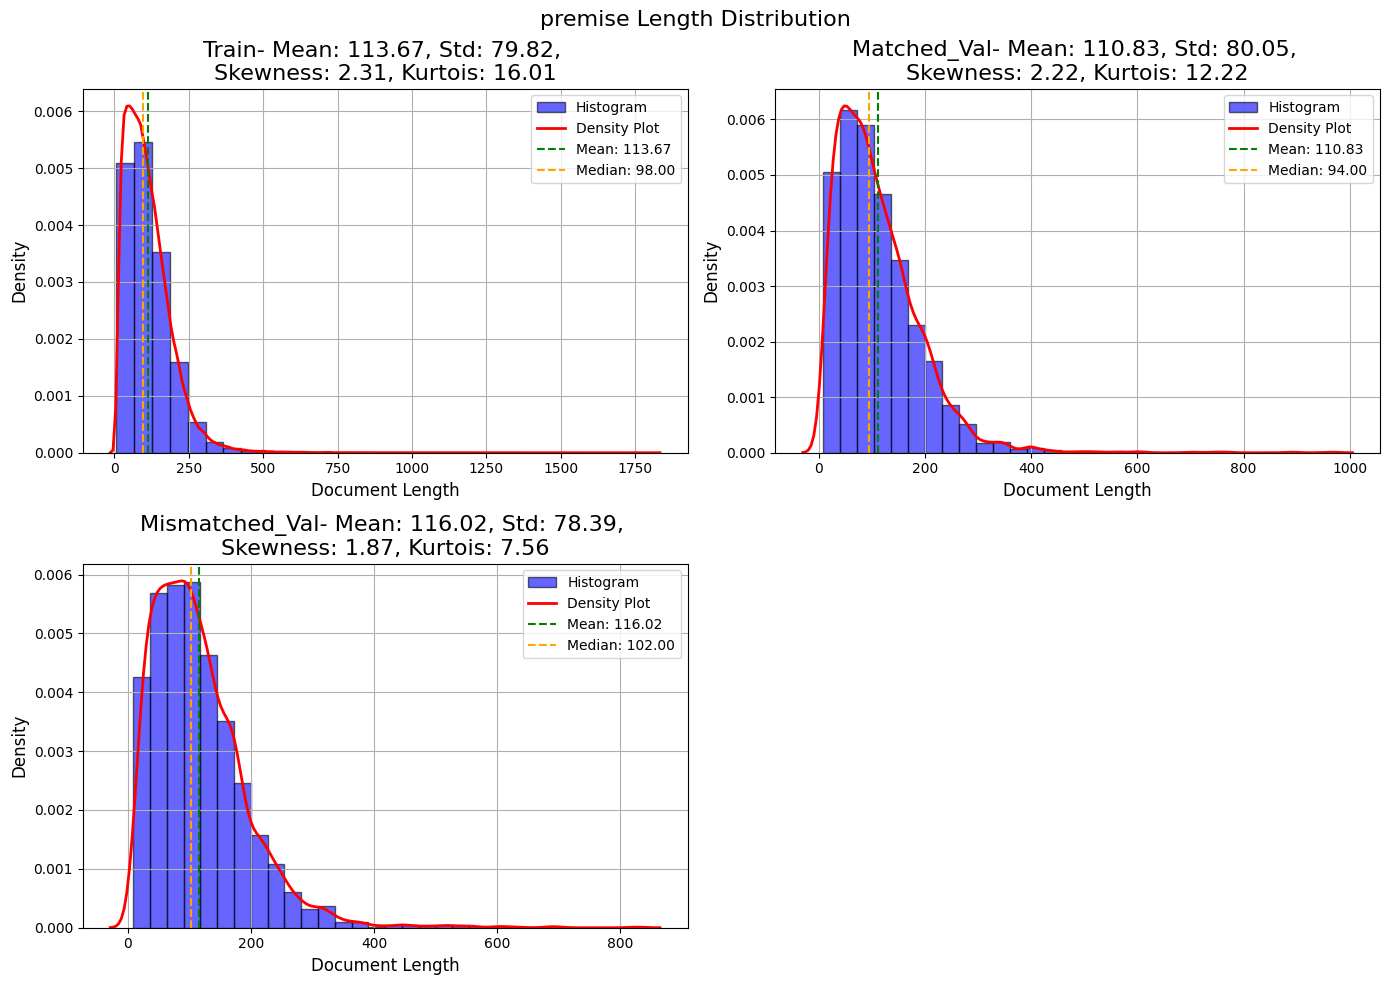

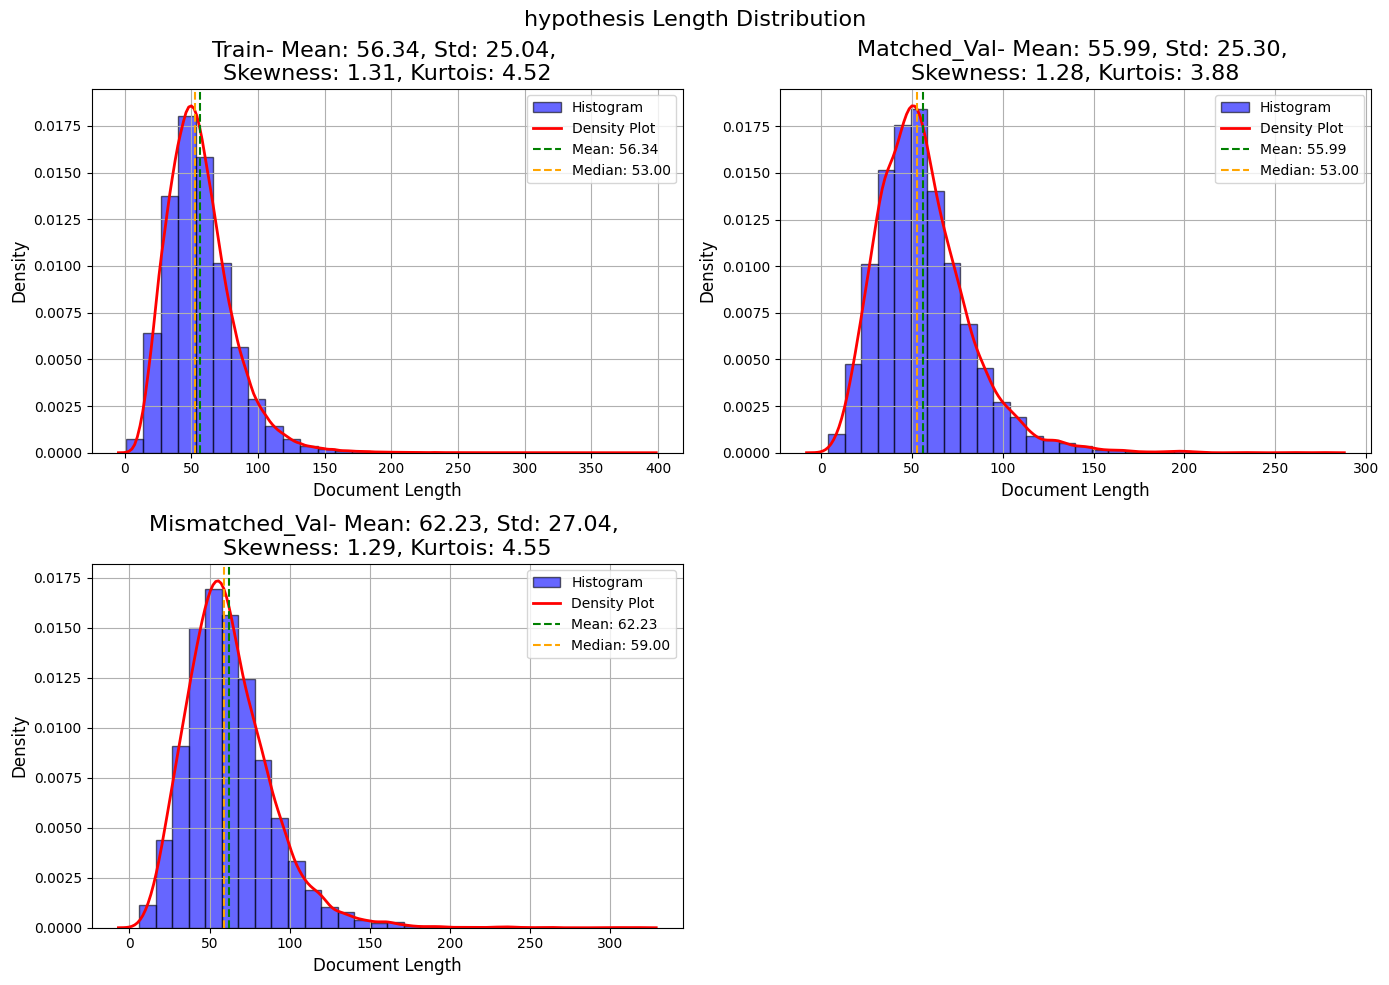

In [ ]:
# premise, hypothesis 길이 분포
# 평균, 표준편차, 왜도, 첨도 계산산
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis

def length_plot(data, name):
    plt.hist(data, bins=30, alpha=0.6, label=f'Histogram', color='blue', edgecolor='black', density=True)
    sns.kdeplot(data, label=f'Density Plot', color='red', linewidth=2)

    mean_value = np.mean(data)
    mean_value = np.mean(data)
    std_dev = np.std(data)
    skewness = skew(data)
    kurt = kurtosis(data)
    median_value = np.median(data)

    plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
    plt.title(f'{name}- Mean: {mean_value:.2f}, Std: {std_dev:.2f}, \nSkewness: {skewness:.2f}, Kurtois: {kurt:.2f}', fontsize=16)
    plt.xlabel('Document Length', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

def final_length_plot(length_type):
    plt.figure(figsize=(14,10))

    for i, (df, name) in enumerate(zip([train_df, matched_val_df, mismatched_val_df],['Train', 'Matched_Val', 'Mismatched_Val'])):
        plt.subplot(2,2,i+1)
        length_plot([len(row[length_type]) for _, row in df.iterrows()], name)

    plt.suptitle(f"{length_type} Length Distribution", fontsize=16)
    plt.tight_layout()
    print("\n\n")

final_length_plot('premise')
final_length_plot('hypothesis')
plt.show()


### 1.7 [My Code] Preprocess Data

- tokenizer: bert base tokenizer를 사용합니다.

- 데이터셋 구성

    1) train: train_df의 80% / 샘플 수 : 314129

    2) val: train_df의 20% / 샘플 수 : 78533

    3) test: matched_val과 mismatched_val_df를 모두 사용합니다 / 샘플 수 : 9815 - 9832

        1) matched_val은 같은 장르 내의 데이터가 학습된 것이기에 mismatched_val_df보다 더 좋은 metric을 보일 것이라 예상합니다.

        2) mismatched_val_df는 zeroshot validation이라 할 수 있기에 metric이 더 안나올 것이라 예상할 수 있습니다..

In [ ]:
# train 데이터의 일부를 val_df로 사용합니다.
# test 데이터는 matched_val과 mismatched_val을 모두 사용하여 두 종류의 테스트 데이터셋으로 사용합니다.
from sklearn.model_selection import train_test_split

train_df = train_df[['premise','hypothesis','label']]
test_df = matched_val_df[['premise','hypothesis','label']]
zeroshot_test_df = mismatched_val_df[['premise','hypothesis','label']]

train_df, val_df = train_test_split(train_df, test_size=test_size)

x_train = train_df[['premise','hypothesis']]
y_train = train_df['label']

x_val = val_df[['premise','hypothesis']]
y_val = val_df['label']

x_test = test_df[['premise','hypothesis']]
y_test = test_df['label']

x_test_zeroshot = zeroshot_test_df[['premise','hypothesis']]
y_test_zeroshot = zeroshot_test_df['label']

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train = label : {y_train.iloc[num]}\n text:{x_train.iloc[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample val= label : {y_val.iloc[num]}\n text:{x_val.iloc[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test = label : {y_test.iloc[num]}\n text:{x_test.iloc[num]}\n")

print(f"x_test_zeroshot shape: {len(x_test_zeroshot)}")
print(f"y_test_zeroshot len: {len(y_test_zeroshot)}\n")
print(f"sample test zeroshot = label : {y_test_zeroshot.iloc[num]}\n text:{x_test_zeroshot.iloc[num]}\n")

x_train len: 314129
y_train len: 314129
sample train = label : 0
 text:premise       Instead, you're still leading with Jacob Weisb...
hypothesis                   Clinton gave an apology to Africa.
Name: 54109, dtype: object

x_val len: 78533
y_val len: 78533
sample val= label : 1
 text:premise       Let's get Clinton's head on straight!
hypothesis             Clinton's head looks wobbly.
Name: 364070, dtype: object

x_test shape: 9815
y_test len: 9815

sample test = label : 1
 text:premise                   The new rights are nice enough
hypothesis    Everyone really likes the newest benefits 
Name: 0, dtype: object

x_test_zeroshot shape: 9832
y_test_zeroshot len: 9832

sample test zeroshot = label : 2
 text:premise       Your contribution helped make it possible for ...
hypothesis    Your contributions were of no help with our st...
Name: 0, dtype: object



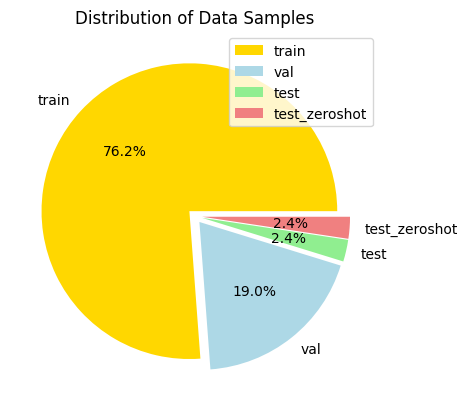

In [ ]:
# 데이터 샘플 수의 분포도입니다.
import matplotlib.pyplot as plt

sizes = [len(x_train), len(x_val), len(x_test), len(x_test_zeroshot)]
labels = ['train', 'val', 'test', 'test_zeroshot']
colors = ['gold', 'lightblue', 'lightgreen', 'lightcoral']
explode = [0.05] * len(sizes)
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%')
plt.title('Distribution of Data Samples')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 허깅페이스 데이터셋 형태로 바꾸기
from datasets import Dataset, DatasetDict
from transformers import logging, DataCollatorWithPadding

# 로깅 수준을 'error'로 설정하여 경고 메시지 숨기기
logging.set_verbosity_error()

# berttokenizer를 이용해 두 문장을 한 문장으로 이을 예정입니다.
# 따라서 premise가 앞에 놓이고 hypothesis가 뒤에 놓이게 됩니다.
# 두 문장을 합해서 max_len보다 길어지면 긴 쪽 데이터를 잘라냅니다.
def tokenize(batch, max_len):

  return tokenizer(
    batch["premise"],
    batch['hypothesis'],
    padding="max_length",
    max_length = max_len,
    truncation="longest_first" ,
    return_tensors = 'pt')

# 데이터 콜레이터를 사용하는 것은 전처리 된 데이터를 배치 단위로 패딩을 하기 위해서입니다.
# 데이터 콜레이터를 사용해야 훈련 과정에서 메모리 효율성이 좋아집니다.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_data = {
    'premise': x_train['premise'],
    'hypothesis': x_train['hypothesis'],
    "label": y_train,
}

val_data = {
    'premise': x_val['premise'],
    'hypothesis': x_val['hypothesis'],
    "label": y_val,
}

test_data = {
    'premise': x_test['premise'],
    'hypothesis': x_test['hypothesis'],
    "label": y_test,
}

test_data_zeroshot = {
    'premise': x_test_zeroshot['premise'],
    'hypothesis': x_test_zeroshot['hypothesis'],
    "label": y_test_zeroshot,
}

train_dataset = Dataset.from_dict(train_data)
train_dataset = train_dataset.map(lambda batch: tokenize(batch, max_len), batched=True)

val_dataset = Dataset.from_dict(val_data)
val_dataset = val_dataset.map(lambda batch: tokenize(batch, max_len), batched=True)

test_dataset = Dataset.from_dict(test_data)
test_dataset = test_dataset.map(lambda batch: tokenize(batch, max_len), batched=True)

test_dataset_zeroshot = Dataset.from_dict(test_data_zeroshot)
test_dataset_zeroshot = test_dataset_zeroshot.map(lambda batch: tokenize(batch, max_len), batched=True)


dataset_dict = DatasetDict(
    {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset,
        "test_data_zeroshot": test_dataset_zeroshot
    }
)

Map:   0%|          | 0/314129 [00:00<?, ? examples/s]

Map:   0%|          | 0/78533 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [41]:
# 모델에 대한 첫번째 샘플의 input shape이나 input의 모습입니다.
import numpy as np
print("input premise and hypothesis")
print(dataset_dict['train'].select(range(5))['premise'][0])
print(dataset_dict['train'].select(range(5))['hypothesis'][0])
print("\n")
print("input_ids shape")
print(np.array(dataset_dict['train'].select(range(5))['input_ids'][0]).shape)
print("\n")
print("attention_mask shape")
print(np.array(dataset_dict['train'].select(range(5))['attention_mask'][0]).shape)
print("\n")
print("label")
print(np.array(dataset_dict['train'].select(range(5))['label'][0]))

input premise and hypothesis
Instead, you're still leading with Jacob Weisberg on Clinton's African apology (Sorry Excuse) and Cullen Murphy's discourse on lying (The Lie of the Land).
Clinton gave an apology to Africa.


input_ids shape
(400,)


attention_mask shape
(400,)


label
0


## 2 [My Code] 훈련

### 2.1 [My Code] Metric 계산

- metric은 acc와 f1을 사용할 예정입니다.

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import os

# compute metrics은 반드시 아래와 같이 dict의 형태로 나와야 합니다.
# metric은 acc와 f1를 사용합니다.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}



### 2.2 [My Code] 훈련 설정

In [ ]:
# 훈련 옵션을 설정합니다.
training_args = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=n_epochs,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=results_dir,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none",
    weight_decay=0.01,
)

def build_trainer():
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_dict["train"],
        eval_dataset=dataset_dict["val"],
        compute_metrics=compute_metrics,
        data_collator = data_collator
    )

    return trainer

trainer = build_trainer()

### 2.3 [My Code] 훈련 이전의 metric

In [ ]:
# fine tuning 이후의 개선 정도를 확인하기 위해 훈련 이전의 metric을 찍어봅니다.
def cal_metrics():
    test_results = trainer.predict(test_dataset=dataset_dict["test"])
    metrics = test_results.metrics
    test_results_zeroshot = trainer.predict(test_dataset=dataset_dict["test_data_zeroshot"])
    metrics_zeroshot = test_results_zeroshot.metrics
    print(f"Test Metrics:", "\n", "loss: ", metrics['test_loss'], "accuracy: ", metrics['test_accuracy'], "f1:", metrics['test_f1'])
    print(f"Test Zeroshot Metrics:", "\n", "loss: ", metrics_zeroshot['test_loss'], "accuracy: ", metrics_zeroshot['test_accuracy'], "f1:", metrics_zeroshot['test_f1'])
    return {'test': metrics, 'test_data_zeroshot': metrics_zeroshot}

initial_metrics = cal_metrics()

Test Metrics: 
 loss:  1.1040453910827637 accuracy:  0.32603158430973 f1: 0.17232406572596048
Test Zeroshot Metrics: 
 loss:  1.1039201021194458 accuracy:  0.3292310821806347 f1: 0.17276399955901137


### 2.4 [Log] 훈련 시작

In [19]:
trainer.train()

{'loss': 1.0519, 'grad_norm': 1.9211081266403198, 'learning_rate': 4.8333333333333334e-05, 'epoch': 1.0}
{'eval_loss': 1.0220638513565063, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.4801166388651904, 'eval_f1': 0.46186126994152565, 'eval_runtime': 202.596, 'eval_samples_per_second': 387.633, 'eval_steps_per_second': 1.515, 'epoch': 1.0}
{'loss': 1.0187, 'grad_norm': 2.1274101734161377, 'learning_rate': 4.666666666666667e-05, 'epoch': 2.0}
{'eval_loss': 0.9999733567237854, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.5037245489157425, 'eval_f1': 0.49992654288957156, 'eval_runtime': 202.59, 'eval_samples_per_second': 387.645, 'eval_steps_per_second': 1.515, 'epoch': 2.0}
{'loss': 1.01, 'grad_norm': 1.8234584331512451, 'learning_rate': 4.5e-05, 'epoch': 3.0}
{'eval_loss': 0.9926491975784302, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.5078120025976341, 'eval_f1': 0.5070523026191482, 'eval_runtime': 202.6475, 'eval_samples_per_second': 387.535, 'ev

TrainOutput(global_step=36840, training_loss=0.9857286848799284, metrics={'train_runtime': 31011.4555, 'train_samples_per_second': 303.884, 'train_steps_per_second': 1.188, 'train_loss': 0.9857286848799284, 'epoch': 30.0})

### 2.5 [My Code] Fine tuning 이후의 metric

In [20]:
# 테스트 데이터셋에 대한 예측 및 평가

metrics = cal_metrics()

Test Metrics: 
 loss:  0.9532849788665771 accuracy:  0.540601120733571 f1: 0.5401042447886971
Test Zeroshot Metrics: 
 loss:  0.9369845986366272 accuracy:  0.5557363710333605 f1: 0.5528805812711728


## 3 [My Code] 결과 plotting

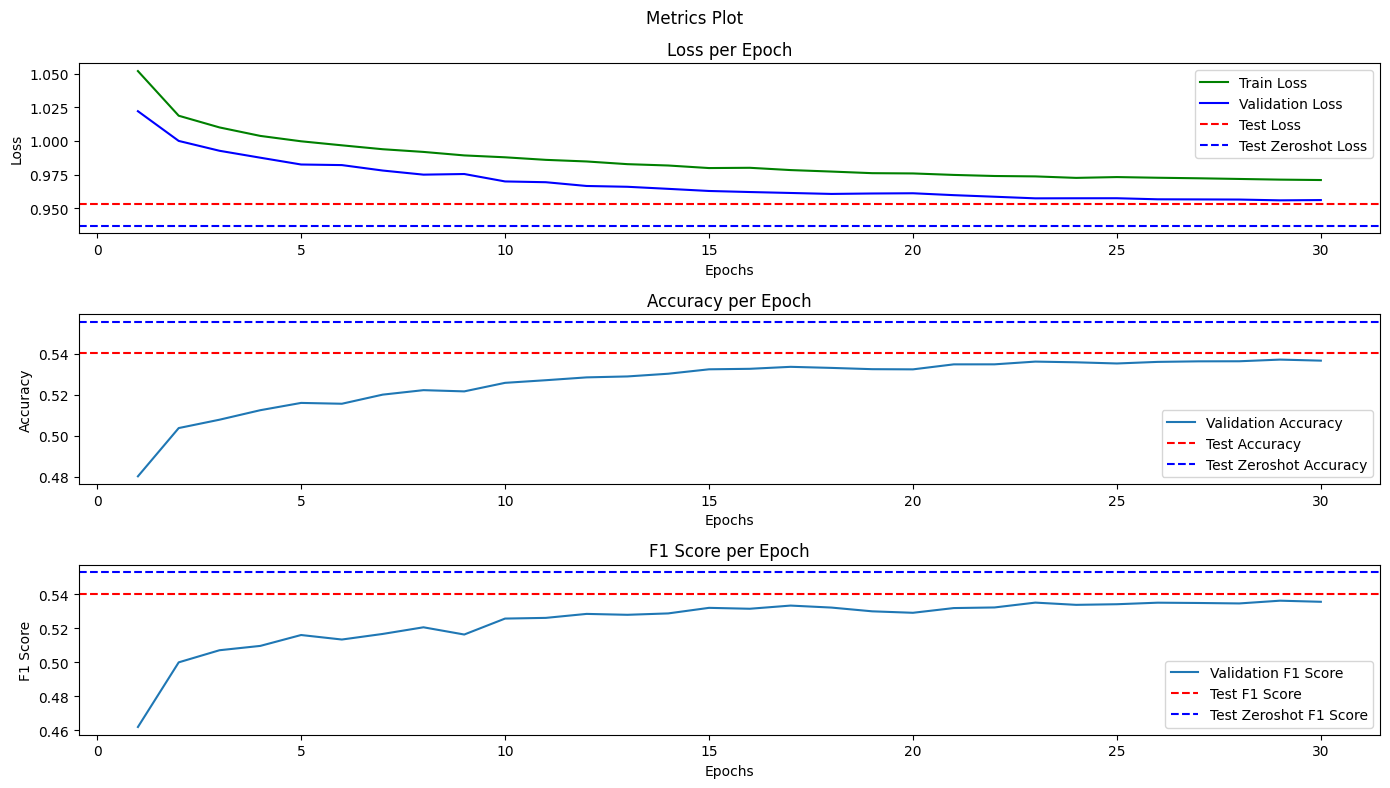

In [25]:
import matplotlib.pyplot as plt

def plotting():
    # 로그 데이터 추출
    log_history = trainer.state.log_history

    # 메트릭 초기화
    epochs = []
    train_loss = []
    val_loss = []
    val_accuracy = []
    val_f1 = []

    # 로그 데이터 분리
    for log in log_history:
        if 'epoch' in log:
            current_epoch = log['epoch']
            if current_epoch not in epochs:
                epochs.append(current_epoch)
            if 'loss' in log:
                train_loss.append(log['loss'])
            if 'eval_loss' in log:
                val_loss.append(log['eval_loss'])
            if 'eval_accuracy' in log:
                val_accuracy.append(log['eval_accuracy'])
            if 'eval_f1' in log:
                val_f1.append(log['eval_f1'])

    test_loss = metrics['test']['test_loss']
    test_accuracy = metrics['test']['test_accuracy']
    test_f1 = metrics['test']['test_f1']

    test_loss_zeroshot = metrics['test_data_zeroshot']['test_loss']
    test_accuracy_zeroshot = metrics['test_data_zeroshot']['test_accuracy']
    test_f1_zeroshot = metrics['test_data_zeroshot']['test_f1']

    # 플로팅
    plt.figure(figsize=(14, 8))

    # 손실 플롯
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, color = 'g', label='Train Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.axhline(y=test_loss_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    # 정확도 및 F1 스코어 플롯
    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.axhline(y=test_accuracy_zeroshot, color='blue', linestyle='--', label='Test Zeroshot Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
    plt.axhline(y=test_f1_zeroshot, color='blue', linestyle='--', label='Test Zeroshot F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.legend()

    plt.suptitle(f"Metrics Plot")
    plt.tight_layout()
    print("\n\n")

plotting()
plt.show()

## 4 [My Code] 모델 결과 차트화

In [24]:
import pandas as pd
# initial metric과 훈련 이후의 metric을 비교합니다.
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 학습 가능한 파라미터 수 출력
trainable_params_lst = [count_trainable_parameters(model) ]
train_runtime_lst = [trainer.state.log_history[-1]['train_runtime']]

result_df = pd.DataFrame([metrics['test']])
result_df.index = ["model"]
result_df['trainable_parameters']  = trainable_params_lst
result_df['train_runtime'] = train_runtime_lst
initial_row = pd.DataFrame([initial_metrics['test']])[["test_loss",'test_accuracy','test_f1']]
initial_row.index = ["initial_model"]
result_df = pd.concat([result_df, initial_row], axis=0).fillna("")

result_df_zeroshot = pd.DataFrame([metrics['test_data_zeroshot']])
result_df_zeroshot.index = ["model"]
result_df_zeroshot['trainable_parameters']  = trainable_params_lst
result_df_zeroshot['train_runtime'] = train_runtime_lst
result_df_zeroshot = result_df_zeroshot.rename(columns = {'test_loss':'test_zeroshot_loss', 'test_accuracy':'test_zeroshot_accuracy','test_f1':'test_zeroshot_f1'})
initial_zeroshot_row = pd.DataFrame([initial_metrics['test_data_zeroshot']])[["test_loss",'test_accuracy','test_f1']]
initial_zeroshot_row = initial_zeroshot_row.rename(columns = {'test_loss':'test_zeroshot_loss', 'test_accuracy':'test_zeroshot_accuracy','test_f1':'test_zeroshot_f1'})
initial_zeroshot_row.index = ["initial_model_zeroshot"]
result_df_zeroshot = pd.concat([result_df_zeroshot, initial_zeroshot_row], axis=0).fillna("")
display(result_df[['test_loss','test_accuracy','test_f1','trainable_parameters', 'train_runtime', 'test_runtime']])
print("\n"*3)
display(result_df_zeroshot[['test_zeroshot_loss','test_zeroshot_accuracy','test_zeroshot_f1','trainable_parameters', 'train_runtime', 'test_runtime']])

,test_loss,test_accuracy,test_f1,trainable_parameters,train_runtime,test_runtime
model,0.953285,0.540601,0.540104,592899.0,31011.4555,25.3462
initial_model,1.104045,0.326032,0.172324,,,


,test_zeroshot_loss,test_zeroshot_accuracy,test_zeroshot_f1,trainable_parameters,train_runtime,test_runtime
model,0.936985,0.555736,0.552881,592899.0,31011.4555,25.3467
initial_model_zeroshot,1.103920,0.329231,0.172764,,,


## 5 [My Code] Conclusion

1) distill bert를 사용하여 accuracy, f1 socre가 많이 상승된 것을 확인할 수 있습니다.

2) 일반 test dataset으로는 54% 정도의 accuracy와 f1, zeroshot으로는 55%의 accuracy와 f1을 기록했습니다.

3) ModernBert가 새로나와 시도해보고 싶었으나 30에폭에 31000초가 걸린 것을 감안하여 시도하지 않았습니다.

4) zeroshot validation이 metric이 더 낮을 거라 예상했지만, 여기선 오히려 1%정도 높게 나와 왜 그런 것인지 확인해보려고 했으나 이 또한 시간 문제에 의해 여기서 멈추었습니다.